In [1]:
import datetime
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import seaborn as sns
import yfinance as yfin
from scipy import stats

yfin.pdr_override()

**Risk**

Standard Deviation- Quantify risk as  percentage

Sharpe Ratio- In Units of the original values

Value at Risk (VaR)- max loss in worst case scenario,
                     Time period and Confidence Iterval
                     
VaR focus only on th downside risk unlike standard deviation which focuses on both upside and downside risk.

## Historical Method

Sort data based on lower to higher value.

For a 95% confidence interval take the 5th percentile of the sorted data.

**No asssummption about the distribution of historical data**

**Equal weights on each days, having a particular trend in the volatility may lead to overstating or understating Var**

**Only depends on Historical Data.**

In [2]:
start= datetime.date.today()-datetime.timedelta(365*5)
end=datetime.date.today()

prices=pd.DataFrame(web.DataReader(["BTC-USD"],start,end)["Adj Close"])
ret= prices.pct_change()
ret= ret.rename(columns={"Adj Close":"Bitcoin"})
ret=ret.dropna()
ret.head()

[*********************100%***********************]  1 of 1 completed


,Bitcoin
Date,
2018-07-12,-0.025943
2018-07-13,0.001483
2018-07-14,0.006103
2018-07-15,0.013308
2018-07-16,0.060084


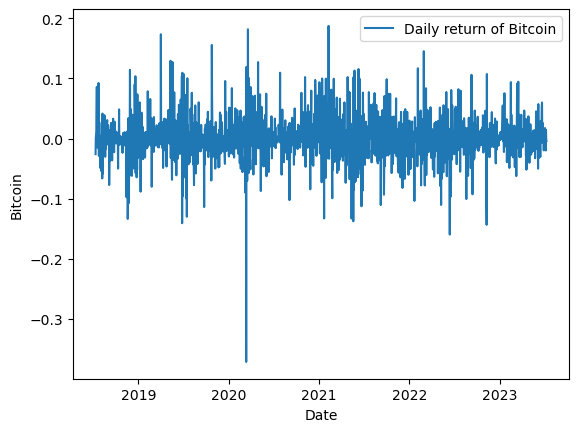

In [3]:
sns.lineplot(x="Date",y="Bitcoin",data=ret,label="Daily return of Bitcoin");

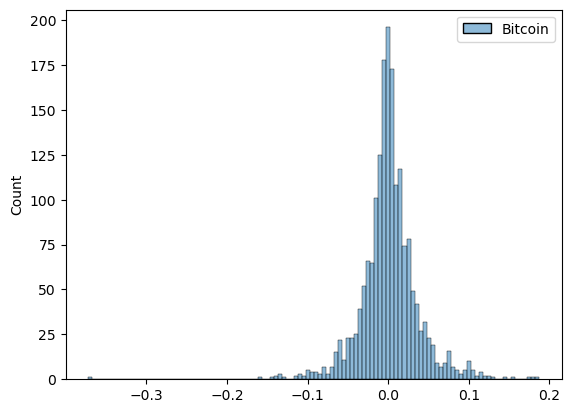

In [4]:
sns.histplot(data=ret);

In [5]:
def getHistoricalVaR(returns,confidenceLevel):
    var=100*np.percentile(returns,100-confidenceLevel)
    print(
        "With a %.2f%% percent confidence level, we can say that the most of our \
        \nportfolio will lose in a day is %.3f%% using the historical  VaR"
        %(confidenceLevel,var)
    )
    

In [6]:
getHistoricalVaR(ret.Bitcoin,95)

With a 95.00% percent confidence level, we can say that the most of our         
portfolio will lose in a day is -5.550% using the historical  VaR


In [7]:
getHistoricalVaR(ret.Bitcoin,99)

With a 99.00% percent confidence level, we can say that the most of our         
portfolio will lose in a day is -9.964% using the historical  VaR


The greater the confidence interval lower the VaR. Since it is being sorted from the lowest to highest.

## Conditional Value at Risk (CVaR)

CVaR or the expected shortfall is calculated by taking average of all the values lower than our VaR

In [8]:
def getHistoricalCVaR(returns,confidencelevel):
    var= np.percentile(returns,100-confidencelevel)
    cvar= returns[returns<var].mean()
    var=var*100
    cvar=cvar*100
    print(
        "With %.2f%% confidence interval the value of VaR is %.3f%% and the Expected Shortfall is %.3f%% ."
        %(confidencelevel,var,cvar)
    )

In [9]:
getHistoricalCVaR(ret.Bitcoin,95)

With 95.00% confidence interval the value of VaR is -5.550% and the Expected Shortfall is -8.251% .


## Parametric Method

Normal distribution is assumed in standard cases but other distribution like students t-distribution can also be used.

Most we can loss or gain= Z(alpha)*standard deviation

Variance and covariance between the return streams must be consiered carefully. 

Models that allow variance to change over time (heteroskedasticity), display a greater degree of accuracy. Engle has argued that Autoregressive Conditional Heteroskedasticity (ARCH) and Generalized Autoregressive Conditional Heteroskedasticity (GARCH) models provide better forecasts of variance and, by extension, better measures of Value at Risk.

*Doesn't work for models with non-linear payoff structure like options.*

**norm.ppf()**- Percent point fucntion assumes normal distributions for the return, takes the value of mean, confidence interval, and standard deviation to calculate VaR.

In [10]:
mean= ret.Bitcoin.mean()
std=ret.Bitcoin.std()
VaR=(100*(stats.norm.ppf(0.05,mean,std))).round(3)
print(
    " For a 95%% confidence interval, with a mean return of %.2f%%,\
    \nstandard deviation of %.2f%%, the parametric value of VaR is %.3f%% "
    %(mean*100,std*100,VaR)
)

 For a 95% confidence interval, with a mean return of 0.15%,    
standard deviation of 3.60%, the parametric value of VaR is -5.772% 


### Parametric method with t-distribution

Higher the degree of freedom, more conservative is the VaR estimate

In [11]:
#Assumption
dof= 4

In [12]:
tVaR= np.sqrt((dof-2)/dof)*stats.t.ppf(0.05,dof)*std-mean
(100*tVaR).round(3)

-5.579

## Monte Carlo Simulation

Not necessarily normal distribution 
Generate a series of random return and calculate similarly like historical